In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(style="darkgrid"); sns.set_context('notebook')
import numpy as np

from sklearn.cluster import KMeans

from highstreets.data import make_dataset as mhsd
from highstreets.visualisation import visualise as vhsd

from dotenv import load_dotenv, find_dotenv
import os

load_dotenv(find_dotenv())

YOY_FILE  = os.environ.get("YOY_FILE")
PROFILE_FILE = os.environ.get("PROFILE_FILE")
PROJECT_ROOT = os.environ.get("PROJECT_ROOT")

#### Load mastercard spend data along with high street profiles 

In [4]:
hsp = pd.read_excel(PROFILE_FILE)
hsd_yoy = pd.read_csv(YOY_FILE, parse_dates=['week_start'])

### Setup data arrays:

In [5]:
hsd_yoy_minimal = mhsd.avg_retail_wd_we(hsd_yoy, 'yoy_')

dates_2020 = ('2020-04-15','2020-10-31')
dates_2020_full = ('2020-01-01','2020-12-31')
dates_2021 = ('2021-02-12', '2021-08-31')
dates_full = ('2020-01-01','2021-12-31')

data_2020 = mhsd.extract_data_array(hsd_yoy_minimal, dates_2020, 'txn_amt')
data_2021 = mhsd.extract_data_array(hsd_yoy_minimal, dates_2021, 'txn_amt')
data_2020_full = mhsd.extract_data_array(hsd_yoy_minimal, dates_2020_full, 'txn_amt')
data_full = mhsd.extract_data_array(hsd_yoy_minimal, dates_full, 'txn_amt')

### Run k-means on 2020, 2021, and full data separately:

In [6]:
n_clus = 3
max_iter = 50
tol = 1e-2

# 2020 data:
kmeans20 = KMeans(init='random', n_clusters=n_clus, 
    random_state=None, max_iter=max_iter, tol=tol, copy_x = True, verbose=0, n_init=10)
kmeans20.fit(np.transpose(data_2020.to_numpy()))

# 2021 data:
kmeans21 = KMeans(init='random', n_clusters=n_clus, 
    random_state=None, max_iter=max_iter, tol=tol, copy_x = True, verbose=0, n_init=10)
kmeans21.fit(np.transpose(data_2021.to_numpy()))

# full data:
kmeansfull = KMeans(init='random', n_clusters=n_clus, 
    random_state=None, max_iter=max_iter, tol=tol, copy_x = True, verbose=0, n_init=10)
kmeansfull.fit(np.transpose(data_full.to_numpy()))

KMeans(init='random', max_iter=50, n_clusters=3, tol=0.01)

## Regressions: trying to summarise trends across time

In [7]:
# Unpooled regression - fit slope and intercept independently for each high street
start_times = {'2020':'2020-04-01','2021':'2021-04-12','full':'2020-04-01'}
tvecs = {'2020':data_2020.index,'2021':data_2021.index,'full':data_full.index}
arrays = {'2020':np.transpose(data_2020.to_numpy()),'2021':np.transpose(data_2021.to_numpy()),'full':np.transpose(data_full.to_numpy())}

fit_lines = {}
reg_model={}

reg_model['2020'],fit_lines['2020'] = mhsd.get_fit_lines(start_times['2020'],tvecs['2020'],arrays['2020'], robust=False)
reg_model['2021'],fit_lines['2021'] = mhsd.get_fit_lines(start_times['2021'],tvecs['2021'],arrays['2021'], robust=False)
reg_model['full'],fit_lines['full'] = mhsd.get_fit_lines(start_times['full'],tvecs['full'],arrays['full'], robust=False)

### Plot each highstreet with lines fit to each recovery period

In [ ]:
vhsd.plot_all_profiles_full({'2020':data_2020,'2021':data_2021,'full':data_full},fit_lines)

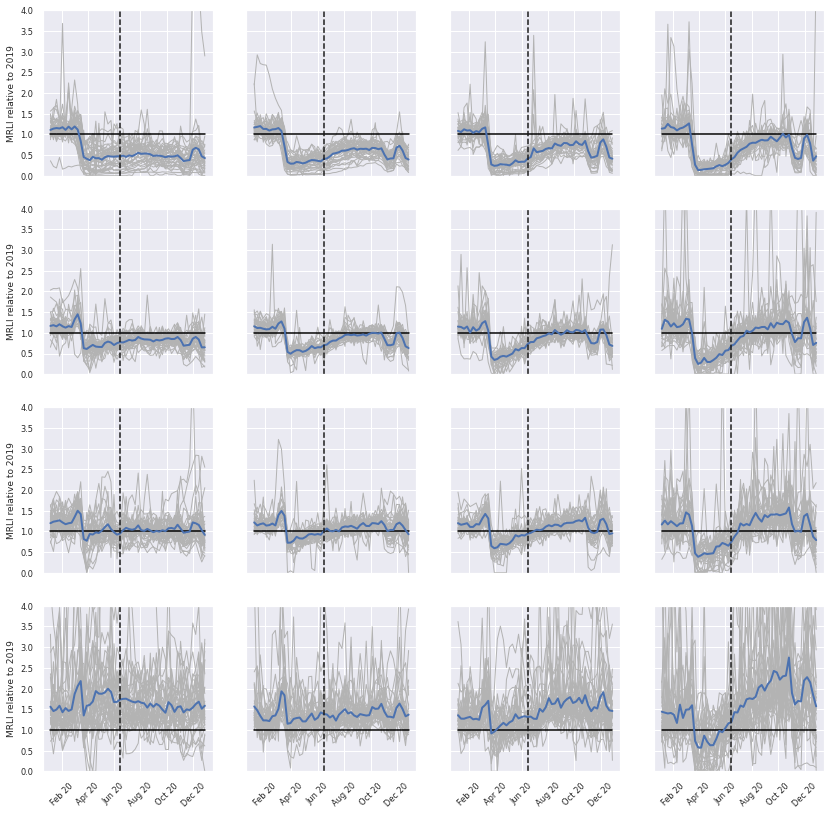

In [60]:
n_grp = 4

_, axes = plt.subplots(n_grp, n_grp,figsize=(14,14), sharey=True, sharex=True)

# columns by which we will sort the highstreets (for example, slope of the best fit line to 2020 recovery and the initial hit in 2020)
#sort_cols = data_2020_full.loc['2020-04-01':'2020-04-30',:].min().to_numpy(), reg_model['2020'].coef_
sort_cols = data_2020_full.loc['2020-03-14':'2020-11-01',:].mean().to_numpy(), reg_model['2020'].coef_

# prepend mean and fit slopes to array for sorting and grouping:
plot_array = np.transpose(data_2020_full.to_numpy())
plot_tvec = data_2020_full.index

array_w_sorting_cols = np.concatenate((sort_cols[0][:,None],sort_cols[1],plot_array), axis=1)

# sort the array by the first sorting column
array_sorted_by_col_one = array_w_sorting_cols[array_w_sorting_cols[:,0].argsort()]

# split the indices into groups by mean
array_split_by_col_one = np.array_split(array_sorted_by_col_one,n_grp)

hs_per_group = int(np.ceil(plot_array.shape[0] / (n_grp*n_grp)))
colors = sns.color_palette("BuGn", n_colors = hs_per_group)

# loop through groups sorting each by slope and splitting by slope
axn=[]
for i, group in enumerate(array_split_by_col_one):
    group_sorted_by_col_two = group[group[:,1].argsort()]
    group_split_by_col_two = np.array_split(group_sorted_by_col_two, n_grp)
    for j, subgroup in enumerate(group_split_by_col_two):
        subgroup = subgroup[subgroup[:,1].argsort()]
        #axes[i][j].set_prop_cycle(color=colors)
        axes[i][j].plot(plot_tvec, np.transpose(subgroup[:,2:]), '0.7',linewidth=1)
        axes[i][j].plot((plot_tvec[0],plot_tvec[-1]),(1,1),'0.0')
        axes[i][j].plot(plot_tvec, subgroup[:,2:].mean(0),'b', linewidth=2)
        axes[i][j].set_ylim([0,4])
        axes[i][j].plot(pd.to_datetime(['2020-06-15','2020-06-15']),[0, 5],'--k')
        axes[i][j].set_xticks(pd.to_datetime(['2020-02','2020-04','2020-06','2020-08','2020-10','2020-12']))
        axes[i][j].set_xticklabels(['Feb 20','Apr 20','Jun 20','Aug 20','Oct 20','Dec 20'], rotation=45)  
    axes[i][0].set_ylabel('MRLI relative to 2019')

plt.savefig(PROJECT_ROOT + '/reports/figures/2020_hs_by_mean_slope.pdf')